# Sentiment analysis with ML classification tecniques

In [1]:
import pandas as pd 
from src.data_processing import Text_processor

df = pd.read_csv("tripadvisor_hotel_reviews.csv")

# convert the continous rating variable to discrete categories
df["label"] = df["Rating"].apply(Text_processor.labelling)
df.head(10)

2024-02-04 18:50:41.721023: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-04 18:50:41.763314: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-04 18:50:41.763345: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-04 18:50:41.764349: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-04 18:50:41.773490: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-04 18:50:41.774438: I tensorflow/core/platform/cpu_feature_guard.cc:1

,Review,Rating,label
0,nice hotel expensive parking got good deal sta...,4,Positive
1,ok nothing special charge diamond member hilto...,2,Negative
2,nice rooms not 4* experience hotel monaco seat...,3,Neutral
3,"unique, great stay, wonderful time hotel monac...",5,Positive
4,"great stay great stay, went seahawk game aweso...",5,Positive
5,love monaco staff husband stayed hotel crazy w...,5,Positive
6,"cozy stay rainy city, husband spent 7 nights m...",5,Positive
7,"excellent staff, housekeeping quality hotel ch...",4,Positive
8,"hotel stayed hotel monaco cruise, rooms genero...",5,Positive
9,excellent stayed hotel monaco past w/e delight...,5,Positive


### Exploratory Data Analysis
In this section some preliminary analysis on the dataset feature and on the its variables will be carried out: 
1. plots will be saved in the plot folder; 
2. Summary statistics will be saved in the EDA.txt file

In [2]:
from src.EDA import EDA

eda = EDA(df)

eda_file = 'EDA.txt'
review = 'Review'
rating = 'label'

# Information about the dataset 
eda.dataset_info(eda_file)
# information about the label colum
eda.summary_statistics(rating, eda_file)
# Investigating possible relationships between reviews lenght and the rating
eda.variables_relationship(review, rating, eda_file)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
 2   label   20491 non-null  object
dtypes: int64(1), object(2)
memory usage: 480.4+ KB
Plot saved at: /home/ziyangfu/Code/Sentiment_Analysis_Models_Comparison/src/../plot/summary_statistics_label.html
Plot saved at: /home/ziyangfu/Code/Sentiment_Analysis_Models_Comparison/src/../plot/summary_statistics_reviews_lenght.html
Plot saved at: /home/ziyangfu/Code/Sentiment_Analysis_Models_Comparison/src/../plot/scatterplot.html


### Text processing: 
prepare and clean the text data before feeding it into a sentiment analysis model. These are the step through which the reviews will undergo: 
1. Text Lowercasing;
2. Tokenization: break the text into individual words or tokens;
3. Removing Punctuation and Stopwords; 
4. Lemmatization:reduce words to their root or base form; 
5. TF-IDF Vectorization: represent each review as a vector based on the importance of words. 


In [3]:
import numpy as np

num_parts = 4
df_chunks = np.array_split(df, num_parts)

cleaned_df = Text_processor.parallel_text_cleaning(df_chunks)
cleaned_df.head(10)

/home/ziyangfu/Code/Sentiment_Analysis_Models_Comparison/Sentiment/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning:

'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.



Chunk 2 has been processed
Chunk 1 has been processed
Chunk 0 has been processed
Chunk 3 has been processed


,Review,Rating,label,reviews_lenght
0,nice hotel expensive park get good deal stay h...,4,Positive,593
1,ok nothing special charge diamond member hilto...,2,Negative,1689
2,nice room 4 experience hotel monaco seattle go...,3,Neutral,1427
3,unique great stay wonderful time hotel monaco ...,5,Positive,600
4,great stay great stay go seahawk game awesome ...,5,Positive,1281
5,love monaco staff husband stay hotel crazy wee...,5,Positive,1002
6,cozy stay rainy city husband spend 7 nights mo...,5,Positive,748
7,excellent staff housekeep quality hotel chock ...,4,Positive,597
8,hotel stay hotel monaco cruise room generous d...,5,Positive,419
9,excellent stay hotel monaco past delight recep...,5,Positive,271


In [4]:
# TD-IDF vectorization 
from sklearn.feature_extraction.text import TfidfVectorizer
tfid = TfidfVectorizer()
X = tfid.fit_transform(cleaned_df["Review"])

### Undersampling to address classes imbalance 

In [5]:
# plotting the classes distribution 
import plotly.express as px
# Create a histogram using Plotly Express
fig = px.histogram(cleaned_df, x='label', title='Sentiment Distribution', labels={'Sentiment': 'Sentiment'})
fig.show()


In [6]:
# use random undersampling to address this issue 
from imblearn.under_sampling import RandomUnderSampler

# Undersample the majority class using RandomUnderSampler
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X, cleaned_df["label"])

# plot the new distribution 
fig = px.histogram(y_resampled, title='Sentiment Distribution')
fig.show()

### Train and Test split and training the selected classification models: 
1. Logistic regression; 
2. Support Vector Machine; 
3. KNeighbours classifier

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from src.classification_models import classifiers 

# Logistic Regression
logistic_regression = LogisticRegression(random_state=42, multi_class="ovr")

#SVM
svm_classifier = SVC(random_state=42, probability=True)

#KNeighbours
knn_classifier = KNeighborsClassifier()

classification_models = classifiers(logistic_regression, 
                                    svm_classifier, knn_classifier)

models = classification_models.models_training(X_train, y_train)

LogisticRegression(multi_class='ovr', random_state=42) training has been completed
SVC(probability=True, random_state=42) training has been completed
KNeighborsClassifier() training has been completed


In [9]:
# Testing 
models_dictionary = classification_models.models_evaluation(models, X_test, y_test)

              precision    recall  f1-score   support

    Negative       0.73      0.78      0.75       453
     Neutral       0.62      0.53      0.57       446
    Positive       0.78      0.84      0.81       412

    accuracy                           0.71      1311
   macro avg       0.71      0.72      0.71      1311
weighted avg       0.71      0.71      0.71      1311



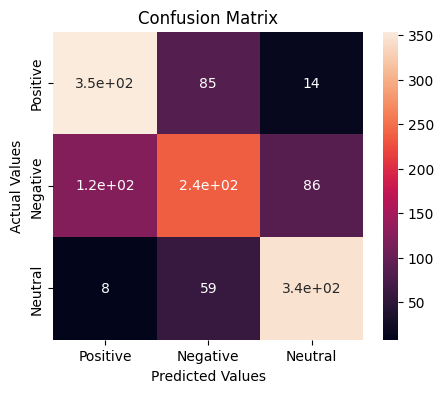

In [10]:
# Logistic regression perfomances 
import matplotlib.pyplot as plt
import seaborn as sns

# Classification report
report = models_dictionary["LogisticRegression(multi_class='ovr', random_state=42)"][0]
print(report)

# Confusion matrix 

cm_df = models_dictionary["LogisticRegression(multi_class='ovr', random_state=42)"][1]
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

              precision    recall  f1-score   support

    Negative       0.75      0.76      0.76       453
     Neutral       0.61      0.63      0.62       446
    Positive       0.82      0.79      0.81       412

    accuracy                           0.72      1311
   macro avg       0.73      0.73      0.73      1311
weighted avg       0.73      0.72      0.72      1311



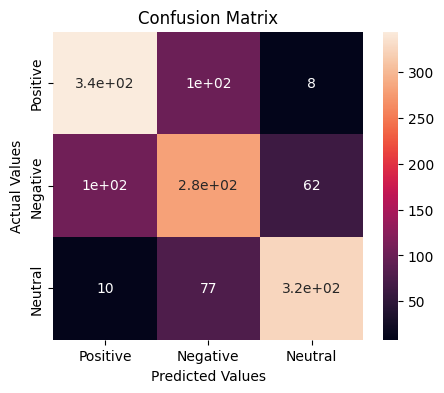

In [12]:
# SVM perfomances 

# Classification report
report = models_dictionary["SVC(probability=True, random_state=42)"][0]
print(report)

# Confusion matrix 

cm_df = models_dictionary["SVC(probability=True, random_state=42)"][1]
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

              precision    recall  f1-score   support

    Negative       0.59      0.62      0.60       453
     Neutral       0.46      0.46      0.46       446
    Positive       0.64      0.61      0.62       412

    accuracy                           0.56      1311
   macro avg       0.56      0.56      0.56      1311
weighted avg       0.56      0.56      0.56      1311



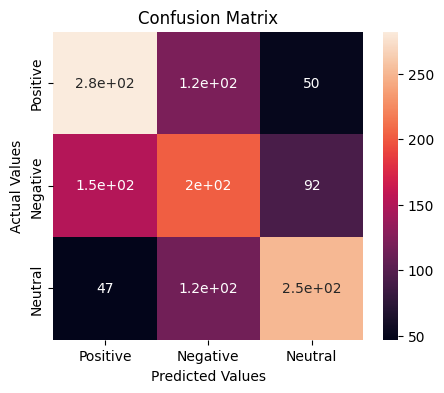

In [13]:
# SVM perfomances 

# Classification report
report = models_dictionary["KNeighborsClassifier()"][0]
print(report)

# Confusion matrix 

cm_df = models_dictionary["KNeighborsClassifier()"][1]
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [14]:
# Testing the models on a unseen review 
review = "if buildings could scream, this one would be screaming:'run way!'"
processed_review = tfid.transform([Text_processor.text_cleaning(review)])
models, predictions, probabilities = classification_models.review_prediction(processed_review)

for i in range(len(models)):
            print(models[i])
            print("{}: {} with probability {}".format(review, 
                                                      predictions[i], probabilities[i]))
            print('\n')



LogisticRegression(multi_class='ovr', random_state=42)
if buildings could scream, this one would be screaming:'run way!': Negative with probability 0.43815250511275977


SVC(probability=True, random_state=42)
if buildings could scream, this one would be screaming:'run way!': Negative with probability 0.5624433030848129


KNeighborsClassifier()
if buildings could scream, this one would be screaming:'run way!': Negative with probability 0.6


